In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading datasets and visualizing raw data points
###### (henceforth referring a1_d1 as DF1 and a2_d2 as DF2)


In [0]:
df1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/a1_d1.csv', header=None).rename(columns={0:'x0', 1:'x1', 2:'target'})
df2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/a1_d2.csv', header=None).rename(columns={0:'x0', 1:'x1', 2:'x2', 3:'target'})

# df1: splitting into features and targets, and then into train and test
df1_x = df1[['x0', 'x1']]
df1_y = df1[['target']]
df1_x_train, df1_x_test, df1_y_train, df1_y_test = train_test_split(df1_x,df1_y,test_size=0.2)

# df2: splitting into features and targets, and then into train and test
df2_x = df2[['x0', 'x1', 'x2']]
df2_y = df2[['target']]
df2_x_train, df2_x_test, df2_y_train, df2_y_test = train_test_split(df2_x,df2_y,test_size=0.2)

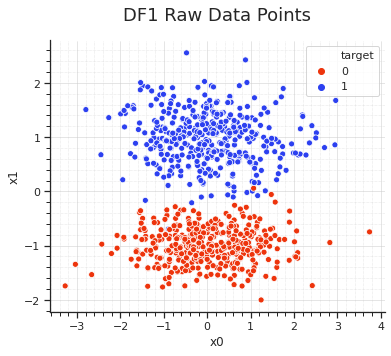

In [4]:
combined_df1_train = df1_x_train.join(df1_y_train, how='outer')

plt.figure(figsize = (6,5))

sns.set()
sns.set_style('ticks')

sns.scatterplot(x = combined_df1_train["x0"], 
                y = combined_df1_train["x1"], 
                hue = combined_df1_train["target"], 
                palette = ['#ed340c', '#2c40f0'],
                legend = 'full')
sns.despine()

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title(label='DF1 Raw Data Points', fontdict={'fontsize':18, 'fontweight':0.01}, pad=20)
plt.show()

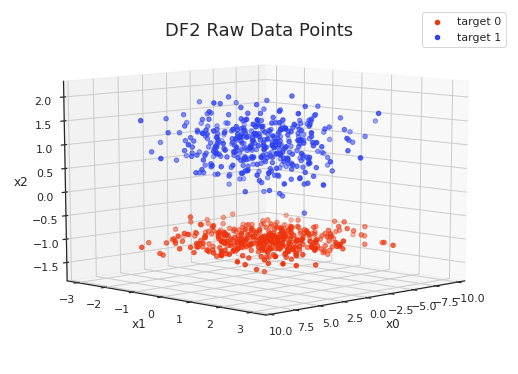

In [33]:
combined_df2_train = df2_x_train.join(df2_y_train, how = 'outer')

fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig, azim=45, elev=10)

x_targ0 = combined_df2_train[combined_df2_train['target'] == 0]['x0']
y_targ0 = combined_df2_train[combined_df2_train['target'] == 0]['x1']
z_targ0 = combined_df2_train[combined_df2_train['target'] == 0]['x2']

x_targ1 = combined_df2_train[combined_df2_train['target'] == 1]['x0']
y_targ1 = combined_df2_train[combined_df2_train['target'] == 1]['x1']
z_targ1 = combined_df2_train[combined_df2_train['target'] == 1]['x2']

ax.scatter(x_targ0, y_targ0, z_targ0, label = 'target 0', c='#ed340c')
ax.scatter(x_targ1, y_targ1, z_targ1, label = 'target 1', c='#2c40f0')

ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.legend()

# plt.minorticks_on()
plt.grid(which='both', linestyle='', linewidth='0.5', color='#e8320b')
plt.title(label='DF2 Raw Data Points', fontdict={'fontsize':18, 'fontweight':0.01}, pad=0)
plt.show()

## Function Definitions

### to determine covariance matrix, when targets are 0 or 1

In [0]:
# df passed must have columns 'x0', 'x1', .... (dimensions), 'target'
def covarianceMatrix(df, target):
  print("prepping for target " + str(target))
  dimensions = df.shape[1] - 1
  target_mask = df.iloc[:, -1] == target
  pb_class = df[target_mask].iloc[:, :-1]
  N_inverse = 1 / (pb_class.shape[0])
  print("(" + str(pb_class.shape[0]) + ") data points")
  
  # mean adjustments
  print("means used to adjust (variables preserved with same names): ")
  for dim in range(0, dimensions):
    itr_var = 'class' + str(target) + '_meanx' + str(dim)
    globals()[itr_var] = pb_class.mean()['x' + str(dim)]
    print('class' + str(target) + '_meanx' + str(dim) + ": " + str(globals()[itr_var]))
    pb_class['x' + str(dim) + '_mean_adj'] = pb_class['x' + str(dim)] - globals()[itr_var]
    
  # determining covariance matrix
  np_array_var = 'class' + str(target) + '_nparray'
  np_array_var = pb_class[list(pb_class.columns[dimensions:])].to_numpy()
  np_array_var_transpose = np.transpose(np_array_var)
  # equivalent to summation of  every [(xi - m1) x (transpose(xi - m1))] for each point xi
  cov_buffer = np.matmul(np_array_var_transpose, np_array_var)
  cov_matrix = cov_buffer.dot(N_inverse)
  print("covariance matrix for target " + str(target) + ":\n", cov_matrix, "\n")  
  
  return cov_matrix 

### to determine w_hat (using Sw and means)

In [0]:
# must be used immediately after covarianceMatrix() to use preserved mean values
def wVectorEstimator(cov0, cov1, dimensions):
  Sw = cov0 + cov1
  print("matrix Sw: \n", Sw)
  Sw_inverse = np.linalg.inv(Sw)
  mean_diff = np.array([[globals()['class1_meanx' + str(dim)] - globals()['class0_meanx' + str(dim)]] for dim in range(0,dimensions)])
  w = np.matmul(Sw_inverse, mean_diff)
  w_hat = w / np.linalg.norm(w)
  print("vector w_hat: \n", w_hat)
  return w_hat

### to plot intersections, given Gaussian parameters


In [0]:
def plotGaussianIntersections(dim, x1, mean1, std1, x2, mean2, std2, intersections):
  fig, a = plt.subplots(1,1)
  a.plot(x1, norm.pdf(x1, mean1, std1))
  a.plot(x2, norm.pdf(x2, mean2, std2))
  a.plot(intersections, norm.pdf(intersections, mean2, std2), 'o')
  a.set_title('x_'+str(dim))
  plt.show()

### utility function to solve quadratic from guassianIntersectionPoints()

In [0]:
def solve(m1, std1, m2, std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

### to find all roots of the Guassian Intersection

In [0]:
def gaussianIntersectionPoints(df):
  dimensions = df.shape[1] - 1
  solutions_raw = []
  # divide into df slices where target is either 0 or 1
  df_class0 = df[df['target'] == 0]
  df_class1 = df[df['target'] == 1]
  # iterate across dimensions
  for dim in range(0, dimensions):
    # sort to get uniform plotting
    x1 = df_class0['x' + str(dim)].sort_values()
    x2 = df_class1['x' + str(dim)].sort_values()
    # means, stddevs
    x_mean_class0 = x1.mean()
    x_std_class0 = x1.std(ddof = 0)
    x_mean_class1 = x2.mean()
    x_std_class1 = x2.std(ddof = 0)
    root = solve(x_mean_class0, x_std_class0, x_mean_class1, x_std_class1)
    solutions_raw.append(list(root))
    plotGaussianIntersections(dim, x1, x_mean_class0, x_std_class0, x2, x_mean_class1, x_std_class1, root)
  return solutions_raw

### utility function to get all combinations of root coordinates

In [0]:
def scramble(sol_points):
  dimensions = len(sol_points)
  if dimensions == 2:
    return np.array(np.meshgrid(sol_points[0], sol_points[1])).T.reshape(-1,dimensions)
  elif dimensions == 3:
    return np.array(np.meshgrid(sol_points[0], sol_points[1], sol_points[2])).T.reshape(-1,dimensions)

### to get actual solution of the Guassian Intersection

In [0]:
def gaussianSolution(df, reference_vector):
  dimensions = df.shape[1] - 1
  solutions_raw = gaussianIntersectionPoints(df)
  min_distance = float('inf')
  for x in scramble(solutions_raw):
    min_buff = abs(x.dot(w_hat))
    if min_buff < min_distance:
      min_distance = min_buff
      solution_coordinates = x
  return solution_coordinates    

### to compute performance scores (Accuracy, F-Score)


In [0]:
def performanceScores(df):
  true_negatives = 0
  true_positives = 0
  false_negatives = 0
  false_positives = 0
  
  for i in df.index:
    if (df['target'][i] == 0) and (df['predicted'][i] == 0):
      true_negatives += 1
    elif (df['target'][i] == 1) and (df['predicted'][i] == 1):
      true_positives += 1
    elif (df['target'][i] == 0) and (df['predicted'][i] == 1):
      false_positives += 1
    if (df['target'][i] == 1) and (df['predicted'][i] == 0):
      false_negatives += 1

  # print cells of confusion matrix
  print("true_negatives:",true_negatives,"  ","false_positives:",false_positives)
  print("false_negatives:",false_negatives,"  ","true_positives:",true_positives)

  # computing scores
  accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_negatives + false_positives) * 100
  precision = (true_positives) / (true_positives + false_positives) * 100
  recall = true_positives / (true_positives + false_negatives) * 100
  f_score = 2 * ((precision * recall) / (precision + recall))

  # print performance scores
  print("-----------------------------------------------")
  print("accuracy:",accuracy)
  print("precision:",precision)
  print("recall:",recall)
  print("f_score:",f_score)

### building an LDA classifier using priors and MLE

In [0]:
def ldaClassifier(df_x, df_y, w_hat, cov_class0, cov_class1, mean_class0, mean_class1):
  dimensions = df_x.shape[1]
  df = df_x.join(df_y, how='outer').reset_index(drop = True)
  for dim in range(0, dimensions):
    df['x'+str(dim)+'_collapsed'] = df['x'+str(dim)] * w_hat[dim][0]
  
  # computing multiplicands, and priors with reference to P(C|x1) = prior*multiplicand
  mcand1_class0 = (1. / ((2 * np.pi) ** (df_x.shape[1] / 2.))) * (1 / np.sqrt(np.linalg.det(cov_class0)))
  mcand1_class1 = (1. / ((2 * np.pi) ** (df_x.shape[1] / 2.))) * (1 / np.sqrt(np.linalg.det(cov_class1)))
  prior_class0 = (df_y[df_y['target'] == 0].shape[0]) / df_y.shape[0]
  prior_class1 = (df_y[df_y['target'] == 1].shape[0]) / df_y.shape[0]
  
  # computing probabilities for each point wrt each class
  df['predicted'] = -1
  for i in df.index:
    x_mean_adjusted_class0 = np.array([df['x'+str(dim)+'_collapsed'][i] - mean_class0[dim] for dim in range(0,dimensions)])
    x_mean_adjusted_class1 = np.array([df['x'+str(dim)+'_collapsed'][i] - mean_class1[dim] for dim in range(0,dimensions)])
    # 
    mcand2_class0 = np.exp(-np.dot(np.dot(x_mean_adjusted_class0, np.linalg.inv(cov_class0)), np.transpose(x_mean_adjusted_class0)) / 2.)
    mcand2_class1 = np.exp(-np.dot(np.dot(x_mean_adjusted_class1, np.linalg.inv(cov_class1)), np.transpose(x_mean_adjusted_class1)) / 2.)
    # 
    prob_for_class0 = prior_class0 * mcand1_class0 * mcand2_class0;
    prob_for_class1 = prior_class1 * mcand1_class1 * mcand2_class1;
    # 
    if prob_for_class0 > prob_for_class1: 
      df['predicted'][i] = 0
    elif prob_for_class0 < prob_for_class1:
      df['predicted'][i] = 1

  return df

## DF1: Binary classification of 2-dimensional data (x0, x1)

### finding vector w_hat to project points onto


In [200]:
cov_class0 = covarianceMatrix(combined_df1_train, 0)
cov_class1 = covarianceMatrix(combined_df1_train, 1)

prepping for target 0
(398) data points
means used to adjust (variables preserved with same names): 
class0_meanx0: 0.00880128531407036
class0_meanx1: -0.991491681570352
covariance matrix for target 0:
 [[0.91519166 0.01492315]
 [0.01492315 0.10912107]] 

prepping for target 1
(402) data points
means used to adjust (variables preserved with same names): 
class1_meanx0: 0.043012510917910446
class1_meanx1: 0.9828064014527367
covariance matrix for target 1:
 [[ 0.95445065 -0.04364426]
 [-0.04364426  0.23277576]] 



In [201]:
w_hat = wVectorEstimator(cov_class0, cov_class1, 2)

matrix Sw: 
 [[ 1.86964231 -0.02872111]
 [-0.02872111  0.34189684]]
vector w_hat: 
 [[0.01852249]
 [0.99982844]]


In [0]:
graph_df1_buff = combined_df1_train.copy()
graph_df1_buff['x0_collapsed'] = df1_x_train['x0'] * w_hat[0][0]
graph_df1_buff['x1_collapsed'] = df1_x_train['x1'] * w_hat[1][0]
graph_df1 = graph_df1_buff.reset_index(drop=True)

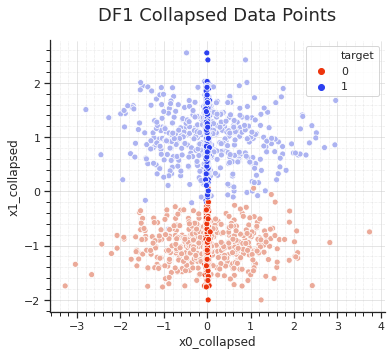

In [203]:
plt.figure(figsize = (6,5))

sns.set()
sns.set_style('ticks')
sns.scatterplot(x = graph_df1["x0"], y = graph_df1["x1"], 
                hue = graph_df1["target"], 
                palette = ['#ebaa99', '#acb3f1'],
                legend = False)
sns.scatterplot(x = graph_df1["x0_collapsed"], y = graph_df1["x1_collapsed"], 
                hue = graph_df1["target"], 
                palette = ['#ed340c', '#2c40f0'], 
                legend = 'full')
sns.despine()

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title(label='DF1 Collapsed Data Points', fontdict={'fontsize':18, 'fontweight':0.01}, pad=20)
plt.show()

### plotting discriminant point on w_hat

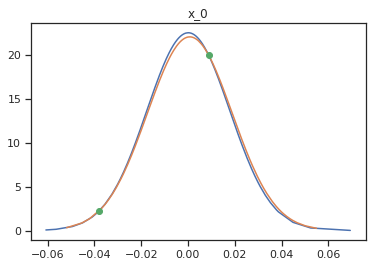

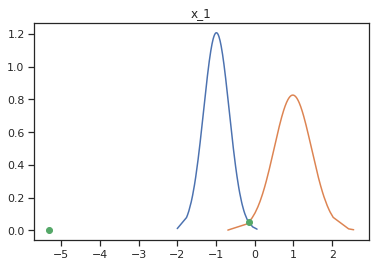

discriminant point on w_hat:
( [0.00016308] , [-0.15865644] )


In [204]:
hist1_buff = graph_df1.copy()[['x0_collapsed', 'x1_collapsed', 'target']]
hist1 = hist1_buff.rename(columns = {'x0_collapsed':'x0', 'x1_collapsed':'x1'})

discriminant = gaussianSolution(hist1, w_hat)
discr_x0 = discriminant[0] * w_hat[0]
discr_x1 = discriminant[1] * w_hat[1]

print("discriminant point on w_hat:")
print("(",discr_x0,",",discr_x1,")")

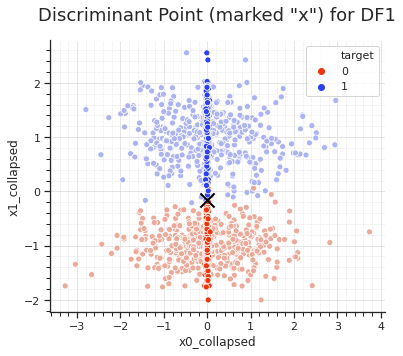

In [205]:
plt.figure(figsize = (6,5))

sns.set()
sns.set_style('ticks')
# original points
sns.scatterplot(x = graph_df1["x0"], y = graph_df1["x1"], 
                hue = graph_df1["target"], 
                palette = ['#ebaa99', '#acb3f1'],
                legend = False)
# collapsed points
sns.scatterplot(x = graph_df1["x0_collapsed"], y = graph_df1["x1_collapsed"], 
                hue = graph_df1["target"], 
                palette = ['#ed340c', '#2c40f0'], 
                legend = 'full')
# discriminant 
sns.scatterplot(x = [discr_x0], y = [discr_x1], marker='x', s = 200, color='#000000', linewidth=2)
sns.despine()

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title(label='Discriminant Point (marked "x") for DF1', fontdict={'fontsize':18, 'fontweight':0.01}, pad=20)
plt.show()

### Max Likelihood Estimation, Building an LDA Classifier

In [206]:
# max likelihood estimation
mle_cov_class0 = covarianceMatrix(hist1, 0)
mle_cov_class1 = covarianceMatrix(hist1, 1)

prepping for target 0
(398) data points
means used to adjust (variables preserved with same names): 
class0_meanx0: 0.0001630217307390194
class0_meanx1: -0.9913215851660323
covariance matrix for target 0:
 [[0.00031399 0.00027637]
 [0.00027637 0.10908364]] 

prepping for target 1
(402) data points
means used to adjust (variables preserved with same names): 
class1_meanx0: 0.0007966988596607472
class1_meanx1: 0.9826377950608353
covariance matrix for target 1:
 [[ 0.00032746 -0.00080826]
 [-0.00080826  0.2326959 ]] 



In [0]:
df1_mean_class0 = [globals()['class0_meanx'+str(dim)] for dim in range(0,2)]
df1_mean_class1 = [globals()['class1_meanx'+str(dim)] for dim in range(0,2)]

### performance scores

In [208]:
# training points against fisher implementation
df1_train_classified = ldaClassifier(df1_x_train, df1_y_train, w_hat, mle_cov_class0, mle_cov_class1, df1_mean_class0, df1_mean_class1)
# test points against lda classifier using priors and MLE
df1_test_classified = ldaClassifier(df1_x_test, df1_y_test, w_hat, mle_cov_class0, mle_cov_class1, df1_mean_class0, df1_mean_class1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [209]:
performanceScores(df1_train_classified)

true_negatives: 396    false_positives: 2
false_negatives: 3    true_positives: 399
-----------------------------------------------
accuracy: 99.375
precision: 99.50124688279301
recall: 99.25373134328358
f_score: 99.37733499377335


In [210]:
performanceScores(df1_test_classified)

true_negatives: 102    false_positives: 0
false_negatives: 1    true_positives: 97
-----------------------------------------------
accuracy: 99.5
precision: 100.0
recall: 98.9795918367347
f_score: 99.48717948717947


## DF2: Binary classification of 3-dimensional data (x0, x1, x2)

### finding vector w_hat to project points onto

In [211]:
cov_class0 = covarianceMatrix(combined_df2_train, 0)
cov_class1 = covarianceMatrix(combined_df2_train, 1)

prepping for target 0
(400) data points
means used to adjust (variables preserved with same names): 
class0_meanx0: 0.08179628935750001
class0_meanx1: 0.08283353338499991
class0_meanx2: -1.001759762725
covariance matrix for target 0:
 [[ 9.55877670e+00 -2.82681174e-01 -1.97723893e-02]
 [-2.82681174e-01  1.04007339e+00 -1.60785237e-03]
 [-1.97723893e-02 -1.60785237e-03  2.49200560e-02]] 

prepping for target 1
(400) data points
means used to adjust (variables preserved with same names): 
class1_meanx0: 0.29795359493250007
class1_meanx1: 0.008409422937500022
class1_meanx2: 1.0050923425850005
covariance matrix for target 1:
 [[8.62809545 0.12295017 0.13872181]
 [0.12295017 1.06551272 0.03353776]
 [0.13872181 0.03353776 0.16281431]] 



In [212]:
w_hat = wVectorEstimator(cov_class0, cov_class1, 3)

matrix Sw: 
 [[18.18687215 -0.159731    0.11894942]
 [-0.159731    2.10558611  0.03192991]
 [ 0.11894942  0.03192991  0.18773436]]
vector w_hat: 
 [[-0.00560076]
 [-0.01886984]
 [ 0.99980626]]


In [0]:
graph_df2_buff = combined_df2_train.copy()
graph_df2_buff['x0_collapsed'] = df2_x_train['x0'] * w_hat[0][0]
graph_df2_buff['x1_collapsed'] = df2_x_train['x1'] * w_hat[1][0]
graph_df2_buff['x2_collapsed'] = df2_x_train['x2'] * w_hat[2][0]
graph_df2 = graph_df2_buff.reset_index(drop=True)

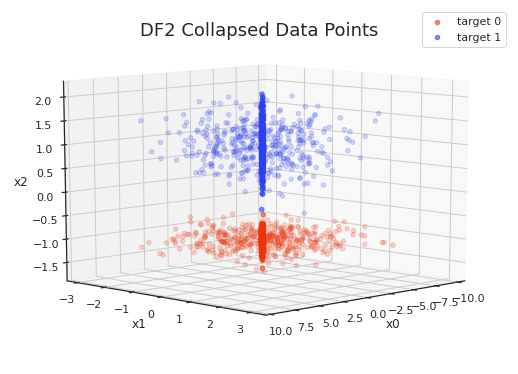

In [214]:
fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig, azim=45, elev=10)

# original points
x_orig0 = graph_df2[graph_df2['target'] == 0]['x0']
y_orig0 = graph_df2[graph_df2['target'] == 0]['x1']
z_orig0 = graph_df2[graph_df2['target'] == 0]['x2']

x_orig1 = graph_df2[graph_df2['target'] == 1]['x0']
y_orig1 = graph_df2[graph_df2['target'] == 1]['x1']
z_orig1 = graph_df2[graph_df2['target'] == 1]['x2']

# collapsed points
x_targ0 = graph_df2[graph_df2['target'] == 0]['x0_collapsed']
y_targ0 = graph_df2[graph_df2['target'] == 0]['x1_collapsed']
z_targ0 = graph_df2[graph_df2['target'] == 0]['x2_collapsed']

x_targ1 = graph_df2[graph_df2['target'] == 1]['x0_collapsed']
y_targ1 = graph_df2[graph_df2['target'] == 1]['x1_collapsed']
z_targ1 = graph_df2[graph_df2['target'] == 1]['x2_collapsed']

ax.scatter(x_orig0, y_orig0, z_orig0, color='#ed340c', alpha=0.2)    # --- '#ebaa99'    
ax.scatter(x_orig1, y_orig1, z_orig1, color='#2c40f0',alpha=0.2)    # --- '#2c40f0'
ax.scatter(x_targ0, y_targ0, z_targ0, label = 'target 0', c='#ed340c', alpha=0.6)
ax.scatter(x_targ1, y_targ1, z_targ1, label = 'target 1', c='#2c40f0', alpha=0.6)

ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.legend()

# plt.minorticks_on()
plt.grid(which='both', linestyle='', linewidth='0.5', color='#e8320b')
plt.title(label='DF2 Collapsed Data Points', fontdict={'fontsize':18, 'fontweight':0.01}, pad=0)
plt.show()

### plotting discriminant point on w_hat

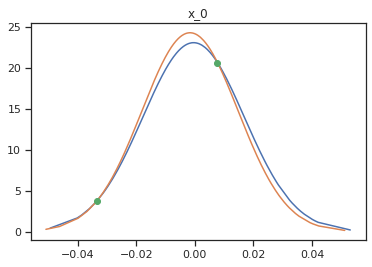

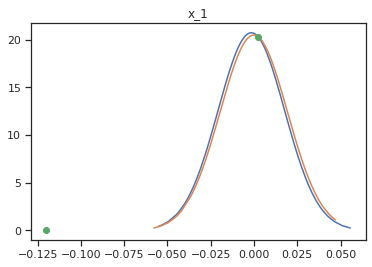

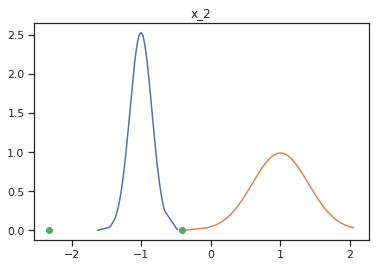

discriminant point on w_hat:
( [0.00018757] , [0.00226881] , [-0.40793212] )


In [215]:
hist2_buff = graph_df2.copy()[['x0_collapsed', 'x1_collapsed', 'x2_collapsed', 'target']]
hist2 = hist2_buff.rename(columns = {'x0_collapsed':'x0', 'x1_collapsed':'x1', 'x2_collapsed':'x2'})

discriminant = gaussianSolution(hist2, w_hat)
discr_x0 = discriminant[0] * w_hat[0]
discr_x1 = discriminant[1] * w_hat[1]
discr_x2 = discriminant[2] * w_hat[2]

print("discriminant point on w_hat:")
print("(",discr_x0,",",discr_x1,",",discr_x2,")")

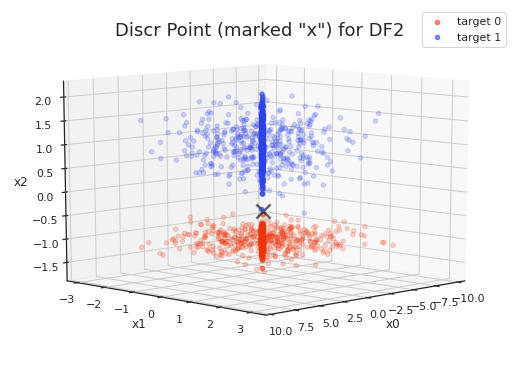

In [216]:
fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig, azim=45, elev=10)

# original points
x_orig0 = graph_df2[graph_df2['target'] == 0]['x0']
y_orig0 = graph_df2[graph_df2['target'] == 0]['x1']
z_orig0 = graph_df2[graph_df2['target'] == 0]['x2']
x_orig1 = graph_df2[graph_df2['target'] == 1]['x0']
y_orig1 = graph_df2[graph_df2['target'] == 1]['x1']
z_orig1 = graph_df2[graph_df2['target'] == 1]['x2']

# collapsed points
x_targ0 = graph_df2[graph_df2['target'] == 0]['x0_collapsed']
y_targ0 = graph_df2[graph_df2['target'] == 0]['x1_collapsed']
z_targ0 = graph_df2[graph_df2['target'] == 0]['x2_collapsed']
x_targ1 = graph_df2[graph_df2['target'] == 1]['x0_collapsed']
y_targ1 = graph_df2[graph_df2['target'] == 1]['x1_collapsed']
z_targ1 = graph_df2[graph_df2['target'] == 1]['x2_collapsed']

ax.scatter(x_orig0, y_orig0, z_orig0, color='#ed340c', alpha=0.2)    # --- '#ebaa99'    
ax.scatter(x_orig1, y_orig1, z_orig1, color='#2c40f0',alpha=0.2)    # --- '#2c40f0'
ax.scatter(x_targ0, y_targ0, z_targ0, label = 'target 0', c='#ed340c', alpha=0.6)
ax.scatter(x_targ1, y_targ1, z_targ1, label = 'target 1', c='#2c40f0', alpha=0.6)
# discriminant
ax.scatter([discr_x0], [discr_x1], [discr_x2], marker='x', s=200, linewidth=2.5, c='#000000', alpha=0.6)

ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.legend()

# plt.minorticks_on()
plt.grid(which='both', linestyle='', linewidth='0.5', color='#e8320b')
plt.title(label='Discr Point (marked "x") for DF2', fontdict={'fontsize':18, 'fontweight':0.01}, pad=0)
plt.show()

### Max Likelihood Estimation, LDA Classifier


In [217]:
# max likelihood estimation
mle_cov_class0 = covarianceMatrix(hist2, 0)
mle_cov_class1 = covarianceMatrix(hist2, 1)

prepping for target 0
(400) data points
means used to adjust (variables preserved with same names): 
class0_meanx0: -0.00045812111058632956
class0_meanx1: -0.0015630551971776074
class0_meanx2: -1.001565683429812
covariance matrix for target 0:
 [[ 2.99844247e-04 -2.98752615e-05  1.10718886e-04]
 [-2.98752615e-05  3.70339674e-04  3.03340327e-05]
 [ 1.10718886e-04  3.03340327e-05  2.49104010e-02]] 

prepping for target 1
(400) data points
means used to adjust (variables preserved with same names): 
class1_meanx0: -0.0016687655746470626
class1_meanx1: -0.00015868443238598148
class1_meanx2: 1.004897617641249
covariance matrix for target 1:
 [[ 2.70650196e-04  1.29940329e-05 -7.76796574e-04]
 [ 1.29940329e-05  3.79397876e-04 -6.32729410e-04]
 [-7.76796574e-04 -6.32729410e-04  1.62751226e-01]] 



In [0]:
df2_mean_class0 = [globals()['class0_meanx'+str(dim)] for dim in range(0,3)]
df2_mean_class1 = [globals()['class1_meanx'+str(dim)] for dim in range(0,3)]

### performance scores

In [219]:
# training points against fisher implementation
df2_train_classified = ldaClassifier(df2_x_train, df2_y_train, w_hat, mle_cov_class0, mle_cov_class1, df2_mean_class0, df2_mean_class1)
# test points against lda classifier using priors and MLE
df2_test_classified = ldaClassifier(df2_x_test, df2_y_test, w_hat, mle_cov_class0, mle_cov_class1, df2_mean_class0, df2_mean_class1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [220]:
performanceScores(df2_train_classified)

true_negatives: 400    false_positives: 0
false_negatives: 0    true_positives: 400
-----------------------------------------------
accuracy: 100.0
precision: 100.0
recall: 100.0
f_score: 100.0


In [221]:
performanceScores(df2_test_classified)

true_negatives: 100    false_positives: 0
false_negatives: 0    true_positives: 100
-----------------------------------------------
accuracy: 100.0
precision: 100.0
recall: 100.0
f_score: 100.0
